In [64]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import cv2
from PIL import Image
%matplotlib notebook

In [65]:
data_path = os.path.join(os.getcwd(), "Data")
matrix_path = os.path.join(data_path, "measurement_matrix.txt")

# Part 1: Affine Factorization
### The goal of this part of the assignment is to implement the Tomasi and Kanade affine structure from motion method as described in [this lecture](https://slazebni.cs.illinois.edu/fall22/lec18_sfm.pptx). You will be working with Carlo Tomasi's 101-frame hotel sequence:


Load the data matrix and normalize the point coordinates by translating them to the mean of the points in each view (see lecture for details).


The file measurement_matrix.txt contains 2d projections in the form 
of an 2M * N  matrix, where M is the number of views and N is the 
number of 3D points. The format is:

x1(1)  x2(1)   x3(1) ... xN(1)

y1(1)  y2(1)  y3(1) ... yN(1)

...

x1(M)  x2(M)   x3(M) ... xN(M)

y1(M)  y2(M)  y3(M) ... yN(M)

where xi(j) and yi(j) are the x- and y- projections of the ith 3D point 
in the jth camera. 

In total, there are 215 3D points visible in all 101 views.

In [66]:
data_matrix = np.loadtxt(matrix_path)
means = np.mean(data_matrix, axis=1, keepdims=True)
norm_matrix = data_matrix - means

m2, n = norm_matrix.shape
m = m2 // 2

print("m: " + str(m))
print("n: " + str(n))

m: 101
n: 215


Apply SVD to the 2M x N data matrix to express it as D = U @ W @ V' (using NumPy notation) where U is a 2Mx3 matrix, W is a 3x3 matrix of the top three singular values, and V is a Nx3 matrix. You can use numpy.linalg.svd to compute this decomposition. Next, derive structure and motion matrices from the SVD as explained in the lecture.

In [67]:
U, W, V_T = np.linalg.svd(norm_matrix)
U_3 = U[:,:3]
SIGMA_3 = np.diag(W[:3])
VT_3 = V_T[:3]

M = U_3 @ np.sqrt(SIGMA_3)
S = np.sqrt(SIGMA_3) @ VT_3

Find the matrix Q to eliminate the affine ambiguity using the method described on slide 32 of the lecture.

In [71]:
coeff = np.empty((4*m,6))
vec = np.empty((4*m))
for i in range(m):
    A = M[2*i:2*i+2]
    A11 = A[0][0]
    A12 = A[0][1]
    A13 = A[0][2]
    A21 = A[1][0]
    A22 = A[1][1]
    A23 = A[1][2]
    coeff[4*i]   = np.array([A11*A11, A11*A12, A11*A13, A12*A12, A12*A13, A13*A13])
    coeff[4*i+1] = np.array([A21*A11, A21*A12, A21*A13, A22*A12, A22*A13, A23*A13])
    coeff[4*i+2] = np.array([A11*A21, A11*A22, A11*A23, A12*A22, A12*A23, A13*A23])
    coeff[4*i+3] = np.array([A21*A21, A21*A22, A21*A23, A22*A22, A22*A23, A23*A23])
    vec[4*i]   = 1
    vec[4*i+1] = 0
    vec[4*i+2] = 0
    vec[4*i+3] = 1  
    
x, residuals, rank, s = np.linalg.lstsq(coeff, vec)
L = np.array([[x[0], x[1], x[2]], [x[1], x[3], x[4]], [x[2], x[4], x[5]]])
print("L:")
print(L)
Q = np.linalg.cholesky(L)
print("Q:")
print(Q)

MQ = M@Q
QS = np.linalg.inv(Q)@S

D = MQ@QS
D_trans = D + means

L:
[[6.35184025e-03 5.59474796e-05 1.06078657e-04]
 [5.59474796e-05 7.22571890e-03 6.52942790e-04]
 [1.06078657e-04 6.52942790e-04 1.44615678e-03]]
Q:
[[0.07969843 0.         0.        ]
 [0.00070199 0.08500133 0.        ]
 [0.001331   0.00767057 0.03722294]]


C:\Users\dista\AppData\Local\Temp\ipykernel_20308\2478342301.py:20: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x, residuals, rank, s = np.linalg.lstsq(coeff, vec)


Use matplotlib to display the 3D structure (in your report, you may want to include snapshots from several viewpoints to show the structure clearly). Discuss whether or not the reconstruction has an ambiguity.

<IPython.core.display.Javascript object>


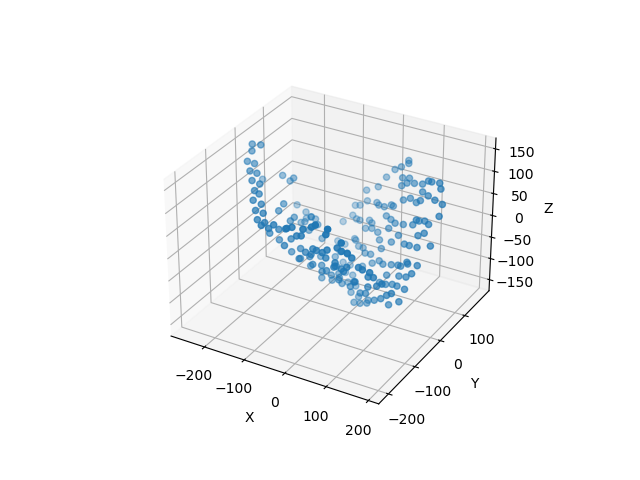

In [80]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(QS[0], QS[1], QS[2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

Display three frames with both the observed feature points and the estimated projected 3D points overlayed. 

<IPython.core.display.Javascript object>


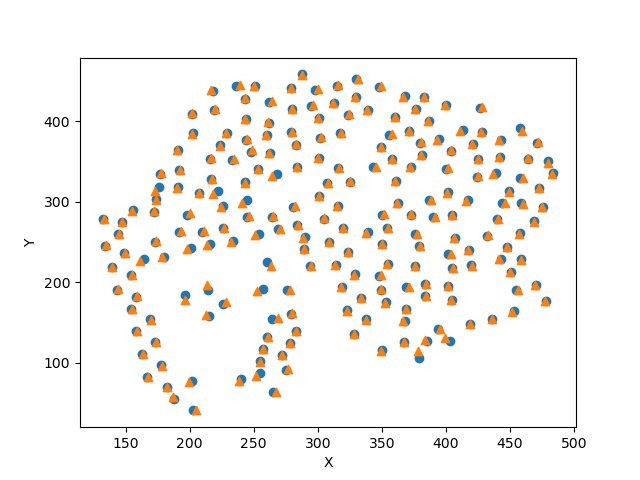

<IPython.core.display.Javascript object>


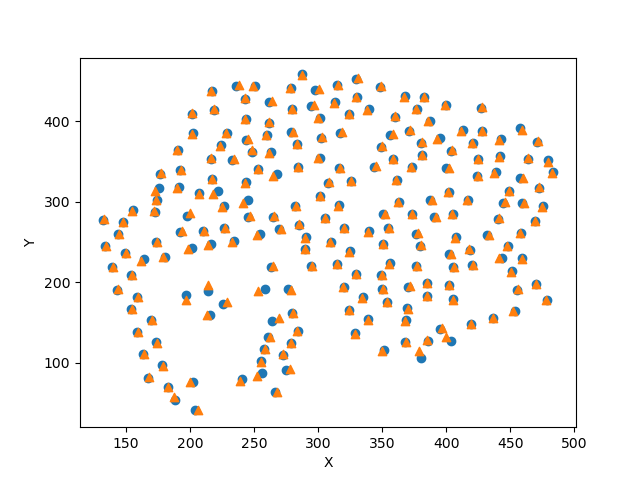

<IPython.core.display.Javascript object>


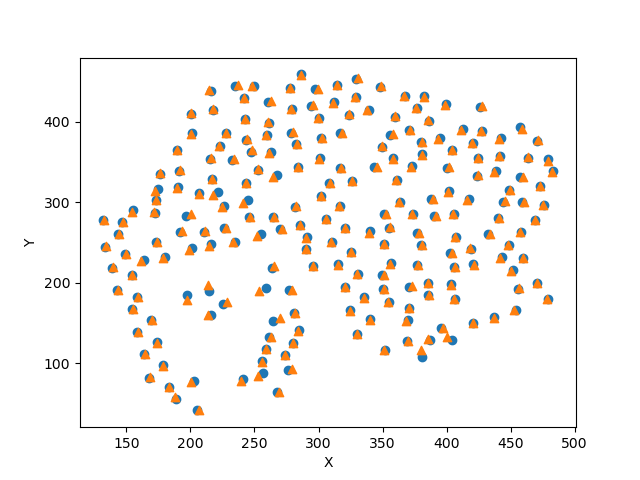

In [82]:
for i in range(3):
    xs = data_matrix[2*i]
    ys = data_matrix[2*i+1]
    
    x_projs = D_trans[2*i]
    y_projs = D_trans[2*i+1]
    
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.scatter(xs, ys, marker='o')
    ax.scatter(x_projs, y_projs, marker='^')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    
    plt.show()

Report your total residual (sum of squared Euclidean distances, in pixels, between the observed and the reprojected features) over all the frames, and plot the per-frame residual as a function of the frame number.

<IPython.core.display.Javascript object>


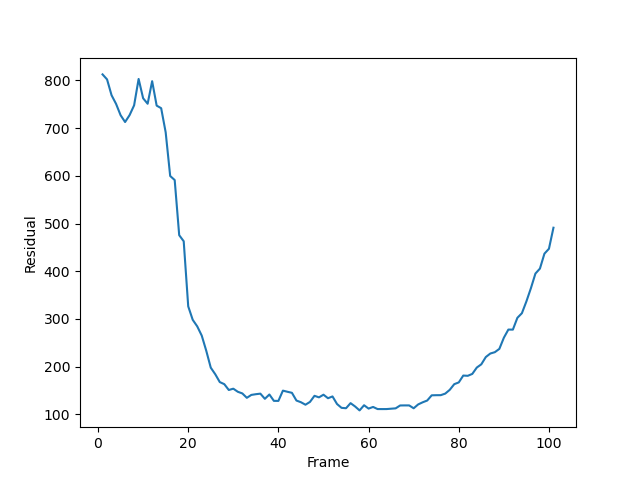

28583.414640984305


In [87]:
residuals = np.empty((m))
for i in range(m):
    coords = data_matrix[2*i:2*i+2]
    proj_coords = D_trans[2*i:2*i+2]
    
    residuals[i] = np.sum(np.linalg.norm(coords-proj_coords)**2, axis=0)
    
total_residual = np.sum(residuals)

xs = np.array([i for i in range(1, m+1)])

fig = plt.figure()
ax = fig.add_subplot()
ax.set_xlabel('Frame')
ax.set_ylabel('Residual')
ax.plot(xs, residuals)

print(total_residual)

plt.show()